Test robustness of the representation to various occlusion to the sample. 

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')
sys.path.append("/n/home12/binxuwang/Github/DiT")
from diffusion import create_diffusion
from models import DiT
from stats_plot_utils import saveallforms, add_rectangles 
from repr_probe_lib import extract_features_DiT, train_pca_sgd_classifiers 
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

In [3]:
import os
from os.path import join
import torch 
import torch as th 
import torch.nn as nn
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


In [5]:
device = "cuda"

In [6]:
# abstract RAVEN dataset
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)

In [7]:
from diffusion import create_diffusion
from models import DiT

DiT_configs = {
    "DiT_XL_1": {"depth": 28, "hidden_size": 1152, "patch_size": 1, "num_heads": 16},
    "DiT_XL_3": {"depth": 28, "hidden_size": 1152, "patch_size": 3, "num_heads": 16},
    "DiT_L_1": {"depth": 24, "hidden_size": 1024, "patch_size": 1, "num_heads": 16},
    "DiT_L_3": {"depth": 24, "hidden_size": 1024, "patch_size": 3, "num_heads": 16},
    "DiT_B_1": {"depth": 12, "hidden_size": 768, "patch_size": 1, "num_heads": 12},
    "DiT_B_3": {"depth": 12, "hidden_size": 768, "patch_size": 3, "num_heads": 12},
    "DiT_S_1": {"depth": 12, "hidden_size": 384, "patch_size": 1, "num_heads": 6},
    "DiT_S_3": {"depth": 12, "hidden_size": 384, "patch_size": 3, "num_heads": 6},
}
DiT_exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
def load_DiT_model(expname, ckpt_step, use_ema=True, 
                   cfg = "DiT_S_1",
                   class_dropout_prob = 1.0,
                   num_classes = 0):
    model_cfg = DiT_configs[cfg]
    model_DiT = DiT(input_size=9,
                in_channels=3, **model_cfg,
                mlp_ratio=4.0,
                class_dropout_prob=class_dropout_prob,
                num_classes=num_classes,
                learn_sigma=True,)

    expdir = join(DiT_exproot, expname)
    ckptdir = join(expdir, "checkpoints")
    ckpt_path = join(ckptdir, f"{ckpt_step}.pt")
    state_dict = th.load(ckpt_path)
    model_DiT.load_state_dict(state_dict['ema' if use_ema else 'model'])
    model_DiT.to("cuda").eval()
    return model_DiT

In [8]:
expname = r"090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
model_DiT = load_DiT_model(expname, 1000000, use_ema=True, cfg = "DiT_S_1", class_dropout_prob = 1.0, num_classes = 0)

In [10]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/repr_geometry_factorization"
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)

### Standard Feature extraction

In [85]:
t_scalar = 25
fetcher = featureFetcher_module()
for i in (5, 8, 11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_DiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_DiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

  0%|          | 0/59 [00:00<?, ?it/s]

blocks0: torch.Size([120000, 81, 384])
blocks2: torch.Size([120000, 81, 384])
blocks5: torch.Size([120000, 81, 384])
blocks8: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


  0%|          | 0/20 [00:00<?, ?it/s]

: 

In [11]:
feature_avg_col = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_last_col = {k: v[:, -1] for k, v in feature_col.items()}
feature_last_col_test = {k: v[:, -1] for k, v in feature_col_test.items()}

In [11]:
t_scalar = 25
fetcher = featureFetcher_module()
for i in (0, 2, 5, 8, 11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
avgtoken_reducer = lambda x: x.mean(dim=1)
feature_avg_col = extract_features_DiT(model_DiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar, feature_reducer=avgtoken_reducer)
feature_avg_col_test = extract_features_DiT(model_DiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar, feature_reducer=avgtoken_reducer)

  0%|          | 0/59 [00:00<?, ?it/s]

blocks0: torch.Size([120000, 384])
blocks2: torch.Size([120000, 384])
blocks5: torch.Size([120000, 384])
blocks8: torch.Size([120000, 384])
blocks11: torch.Size([120000, 384])


  0%|          | 0/20 [00:00<?, ?it/s]

blocks0: torch.Size([40000, 384])
blocks2: torch.Size([40000, 384])
blocks5: torch.Size([40000, 384])
blocks8: torch.Size([40000, 384])
blocks11: torch.Size([40000, 384])


### Classifier Geometry via PCA

In [12]:
list(feature_avg_col.keys())

['blocks5', 'blocks8', 'blocks11']

In [15]:
# Compute PCA and spectrum
X = feature_avg_col['blocks11'].cuda()
# S contains singular values of X (not XX^T)
# If we want eigenvalues of XX^T, need to square S
U, S, V = torch.pca_lowrank(X, q=384)
S_XXt = S.pow(2)  # These are eigenvalues of XX^T

Feature matrix shape: torch.Size([120000, 384])
Top 40 singular values: [3047.7158   894.0188   738.9937   674.0464   641.4445   584.64746
  568.39435  551.1284   526.7806   511.6844   506.1598   501.60803
  457.3473   447.28748  427.12125  424.3757   405.01236  399.72592
  392.8858   382.04736  376.99625  360.72177  345.21164  335.624
  316.10217  302.0772   301.28848  300.62756  296.9425   288.1714
  281.92725  274.10526  256.26904  236.7051   233.14235  228.28741
  219.83736  209.66324  207.97783  201.88118]


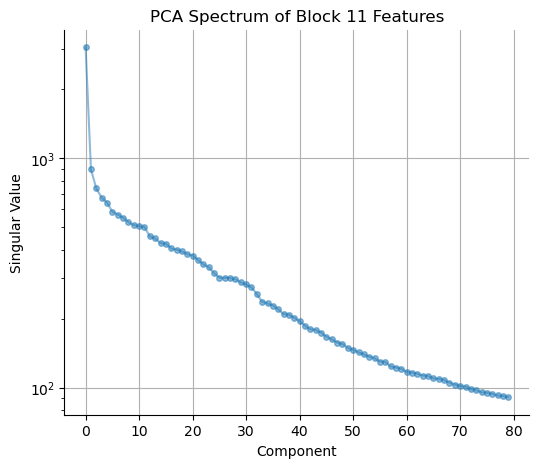

In [25]:
plt.figure(figsize=(6,5))
plt.plot(S.cpu().numpy()[:80], '-o', markersize=4, alpha=0.5)
plt.yscale('log')
plt.grid()
plt.xlabel('Component')
plt.ylabel('Singular Value')
plt.title('PCA Spectrum of Block 11 Features')
print("Feature matrix shape:", X.shape)
print("Top 40 singular values:", S[:40].cpu().numpy())

### Low dimensionality of readouts

In [12]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train, y_test,
    PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=500, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks0
Epoch [1/5000], Loss: 3.9023, Accuracy: 0.0211
Epoch [500/5000], Loss: 2.9512, Accuracy: 0.1898
Epoch [1000/5000], Loss: 2.8028, Accuracy: 0.2188
Test Accuracy: 0.2160
Epoch [1500/5000], Loss: 2.7190, Accuracy: 0.2345
Epoch [2000/5000], Loss: 2.6645, Accuracy: 0.2439
Test Accuracy: 0.2426
Epoch [2500/5000], Loss: 2.6247, Accuracy: 0.2526
Epoch [3000/5000], Loss: 2.5941, Accuracy: 0.2595
Test Accuracy: 0.2574
Epoch [3500/5000], Loss: 2.5696, Accuracy: 0.2653
Epoch [4000/5000], Loss: 2.5495, Accuracy: 0.2681
Test Accuracy: 0.2671
Epoch [4500/5000], Loss: 2.5321, Accuracy: 0.2728
Epoch [5000/5000], Loss: 2.5173, Accuracy: 0.2753
Test Accuracy: 0.2737
Test Accuracy: 0.2737
Layer blocks0 - PCA time: 0.02s, PCA transform time: 0.11s, Training time: 33.05s
Processing layer: blocks2
Epoch [1/5000], Loss: 3.8396, Accuracy: 0.0228
Epoch [500/5000], Loss: 1.7501, Accuracy: 0.4833
Epoch [1000/5000], Loss: 1.5103, Accuracy: 0.5373
Test Accuracy: 0.5284
Epoch [1500/5000], L

In [13]:
for layer in results_col.keys():
    print(layer, "Full 40 way readout accuracy:", results_col[layer].test_record.accuracy.max())

blocks0 Full 40 way readout accuracy: 0.273675
blocks2 Full 40 way readout accuracy: 0.621725
blocks5 Full 40 way readout accuracy: 0.95315
blocks8 Full 40 way readout accuracy: 0.99605
blocks11 Full 40 way readout accuracy: 0.998


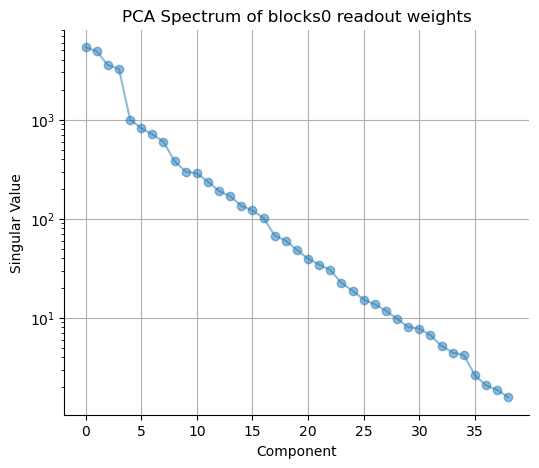

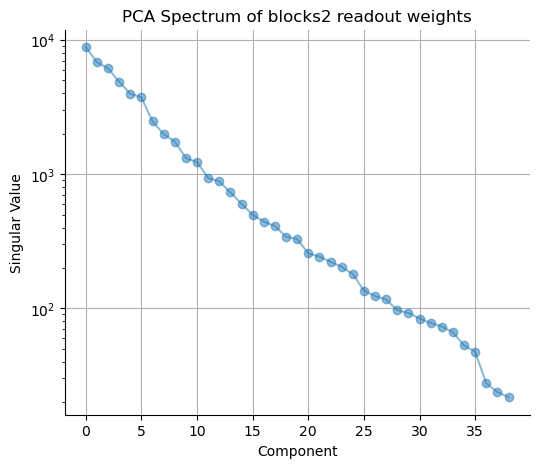

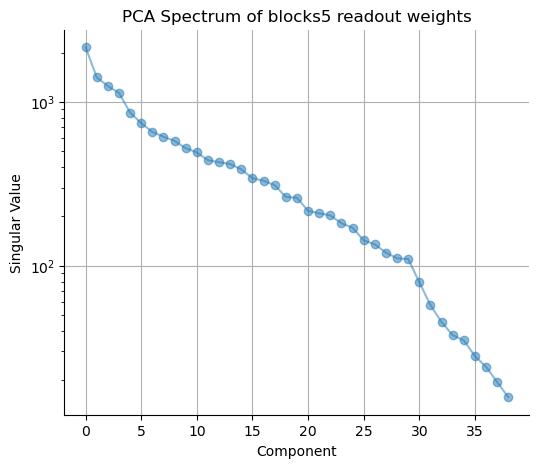

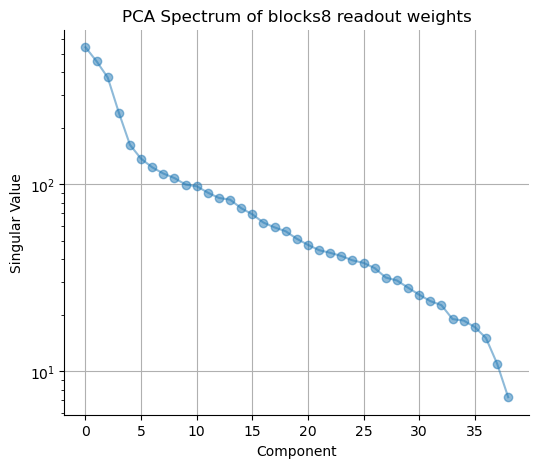

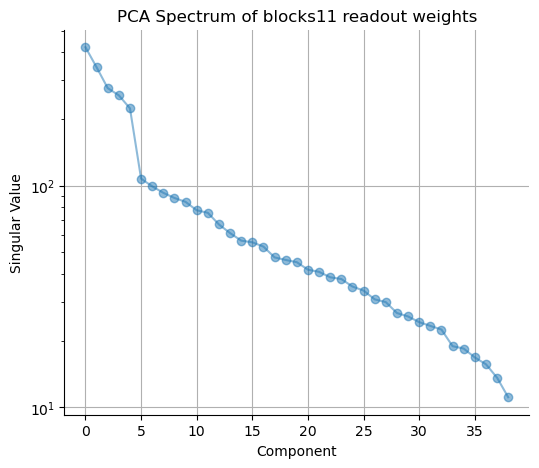

In [14]:
for layer in list(results_col.keys()):
    readout_layer = model_PCA_col[layer]
    W = readout_layer.fc.weight.data
    U, S, V = torch.pca_lowrank(W.detach(), q=40)
    S_XXt = S.pow(2)  # These are eigenvalues of XX^T
    plt.figure(figsize=(6,5))
    plt.plot(S_XXt.cpu().numpy()[:39], '-o', markersize=6, alpha=0.5)
    plt.yscale('log')
    plt.grid()
    plt.xlabel('Component')
    plt.ylabel('Singular Value')
    plt.title(f'PCA Spectrum of {layer} readout weights')

### Training factorized readout

In [15]:
y_attr_train = y_train // 10
y_attr_test = y_test // 10
y_rel_train = y_train % 10
y_rel_test = y_test % 10

In [16]:
model_PCA_col_attr, PC_proj_col_attr, results_col_attr = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_attr_train, y_attr_test,
    PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=500, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

model_PCA_col_rel, PC_proj_col_rel, results_col_rel = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_rel_train, y_rel_test,
    PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=500, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks0
Epoch [1/5000], Loss: 3.8281, Accuracy: 0.0306
Epoch [500/5000], Loss: 1.4876, Accuracy: 0.3750
Epoch [1000/5000], Loss: 1.3430, Accuracy: 0.3797
Test Accuracy: 0.3819
Epoch [1500/5000], Loss: 1.3130, Accuracy: 0.3805
Epoch [2000/5000], Loss: 1.3020, Accuracy: 0.3828
Test Accuracy: 0.3854
Epoch [2500/5000], Loss: 1.2960, Accuracy: 0.3840
Epoch [3000/5000], Loss: 1.2920, Accuracy: 0.3834
Test Accuracy: 0.3862
Epoch [3500/5000], Loss: 1.2899, Accuracy: 0.3840
Epoch [4000/5000], Loss: 1.2889, Accuracy: 0.3845
Test Accuracy: 0.3847
Epoch [4500/5000], Loss: 1.2871, Accuracy: 0.3859
Epoch [5000/5000], Loss: 1.2863, Accuracy: 0.3856
Test Accuracy: 0.3876
Test Accuracy: 0.3876
Layer blocks0 - PCA time: 0.02s, PCA transform time: 0.10s, Training time: 32.65s
Processing layer: blocks2
Epoch [1/5000], Loss: 3.8019, Accuracy: 0.0268
Epoch [500/5000], Loss: 1.3678, Accuracy: 0.4541
Epoch [1000/5000], Loss: 1.2168, Accuracy: 0.4661
Test Accuracy: 0.4616
Epoch [1500/5000], L

In [17]:
dimred_str = "avgtoken"
ckpt_str = "1000000"
t_str = "25"
pkl.dump(model_PCA_col, open(join(figexpdir,f"model_PCA_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
pkl.dump(model_PCA_col_attr, open(join(figexpdir,f"model_PCA_col_attr_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
pkl.dump(model_PCA_col_rel, open(join(figexpdir,f"model_PCA_col_rel_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
pkl.dump(results_col, open(join(figexpdir,f"results_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
pkl.dump(results_col_attr, open(join(figexpdir,f"results_col_attr_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
pkl.dump(results_col_rel, open(join(figexpdir,f"results_col_rel_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
pkl.dump(PC_proj_col_attr, open(join(figexpdir,f"PC_proj_col_attr_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
pkl.dump(PC_proj_col_rel, open(join(figexpdir,f"PC_proj_col_rel_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))

In [18]:
layer = 'blocks11'
synop_df = []
for layer in list(results_col.keys()):
    results_col_attr[layer].pred_cls
    results_col_rel[layer].pred_cls
    factorized_pred = results_col_attr[layer].pred_cls * 10 + results_col_rel[layer].pred_cls 
    factorized_pred = factorized_pred.to(int).cpu()
    factorized_acc = factorized_pred.eq(y_test).float().mean().item()
    attr_acc = results_col_attr[layer].test_record.accuracy.max()
    rel_acc = results_col_rel[layer].test_record.accuracy.max()
    full_acc = results_col[layer].test_record.accuracy.max()
    synop_df.append({"layer": layer, "factorized accuracy": factorized_acc, "attribute accuracy": attr_acc, "relation accuracy": rel_acc, "full 40 way readout accuracy": full_acc}, )
    print(f"{layer} factorized accuracy: {factorized_acc:.4f}, attribute accuracy: {attr_acc:.4f}, relation accuracy: {rel_acc:.4f}, full 40 way readout accuracy: {full_acc:.4f}")

synop_df = pd.DataFrame(synop_df)


blocks0 factorized accuracy: 0.1141, attribute accuracy: 0.3876, relation accuracy: 0.2915, full 40 way readout accuracy: 0.2737
blocks2 factorized accuracy: 0.2195, attribute accuracy: 0.4782, relation accuracy: 0.4278, full 40 way readout accuracy: 0.6217
blocks5 factorized accuracy: 0.7226, attribute accuracy: 0.9297, relation accuracy: 0.7644, full 40 way readout accuracy: 0.9532
blocks8 factorized accuracy: 0.9611, attribute accuracy: 0.9975, relation accuracy: 0.9631, full 40 way readout accuracy: 0.9960
blocks11 factorized accuracy: 0.9759, attribute accuracy: 0.9989, relation accuracy: 0.9767, full 40 way readout accuracy: 0.9980


In [1]:
synop_df

NameError: name 'synop_df' is not defined

In [20]:
synop_df.to_csv(join(figexpdir, "factorized_readout_synopsis.csv"), index=False)

### Error analysis

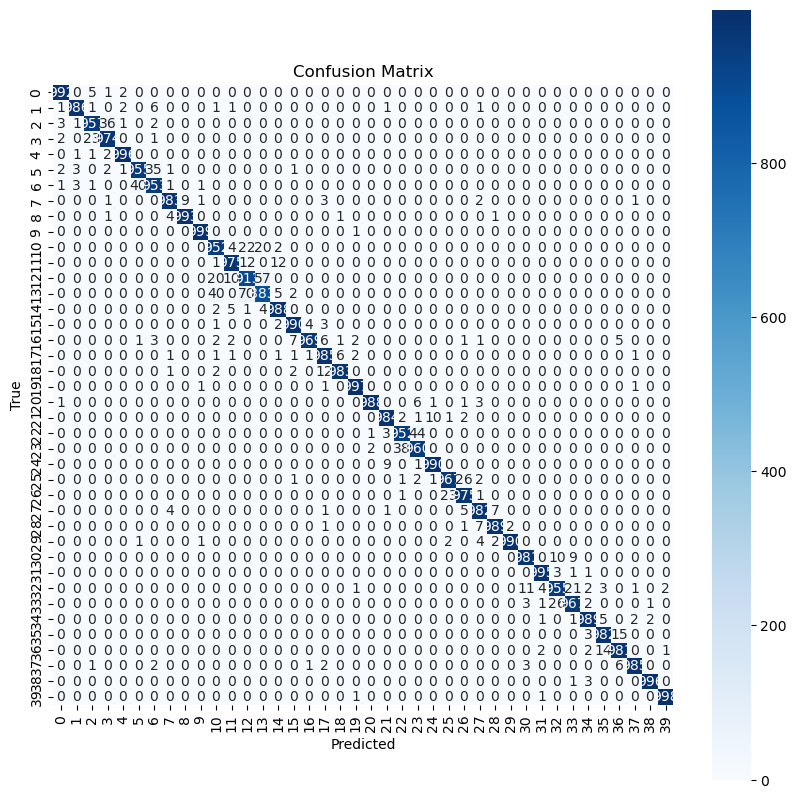

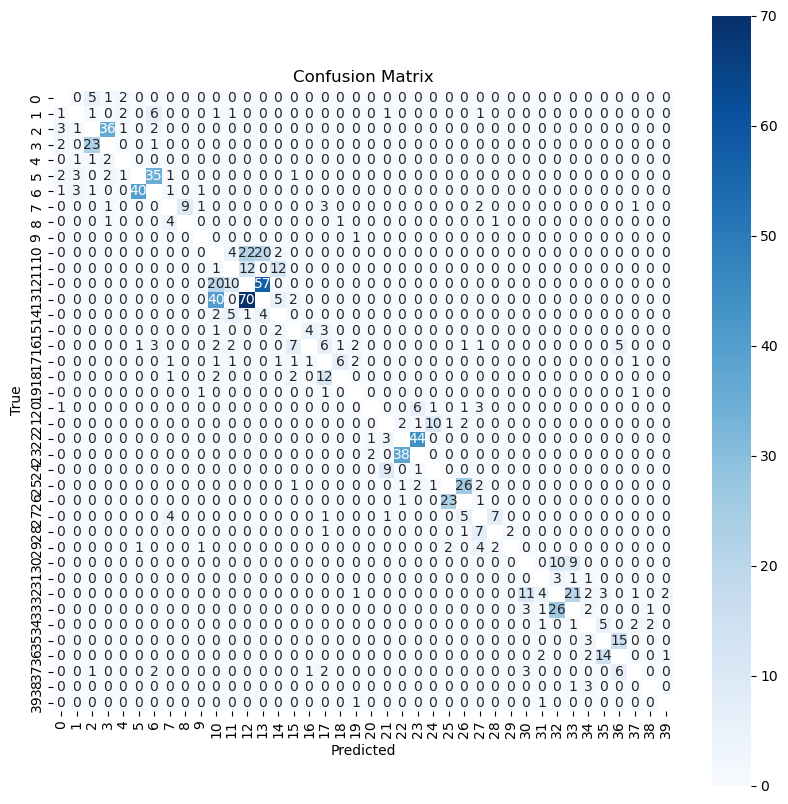

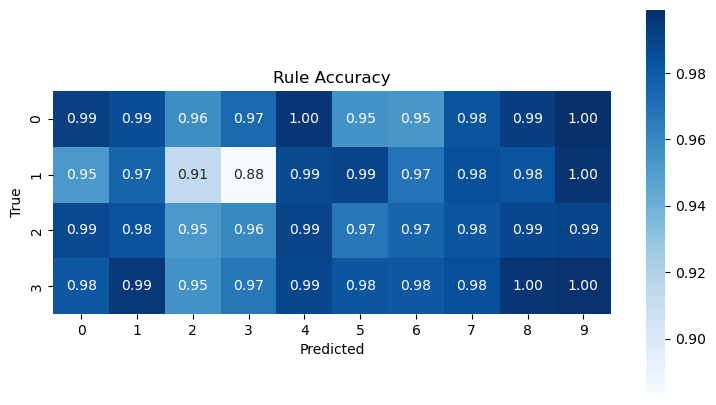

In [60]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
layer = 'blocks11'
results_col_attr[layer].pred_cls
results_col_rel[layer].pred_cls
factorized_pred = results_col_attr[layer].pred_cls * 10 + results_col_rel[layer].pred_cls 
factorized_pred = factorized_pred.to(int).cpu()
factorized_acc = factorized_pred.eq(y_test).float().mean()

conf_mat = confusion_matrix(y_test.cpu(), factorized_pred)
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.axis('image')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

conf_mat_nodiag = conf_mat.copy().astype(float)
np.fill_diagonal(conf_mat_nodiag, np.nan)
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat_nodiag, annot=True, fmt='.0f', cmap='Blues')
plt.axis('image')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (diagonal masked)')
plt.show()

rule_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)
plt.figure(figsize=(9,5))
sns.heatmap(rule_acc.reshape(4, 10), annot=True, fmt='.2f', cmap='Blues')
plt.axis('image')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Rule Accuracy')
plt.show()
